# Using XGBoost to Predict House Pricing
Let's try to use an Extreme Gradient Boosting regressor to crack this [Kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) on Adavanced Regression Techniques :) 

## First of all, let's load the tools of the trade

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import math

## ... and our training and test data

In [2]:
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

train.shape

(1460, 81)

In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In our training dataset we have 1460 houses described by 79 variables (with a mix of categorical and numerical, and I'm excluding the `ID`) and their associated selling price (`SellPrice`).

Let's check now for missing values. I expect a high number as the house might not have all the amenities and characteristics included in the list of variables. We'll need to handle this properly in our model.

In [4]:
missing_values_count = train.isna().sum()
print("\nMissing Values Count:")
print(missing_values_count)


Missing Values Count:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


## Let's split categorical from numerical fields...

In [5]:
categorical_vars = train.select_dtypes(include='object')  # Select object data type columns
numerical_vars = train.select_dtypes(exclude='object')  # Select non-object (numeric) data type columns


## ... and create some boxplots for the former.
This is always a good first step in any exploratory analysis. The section below I'm going to plot the bloxplot of `SalePrice` against each level of the categorical fields.


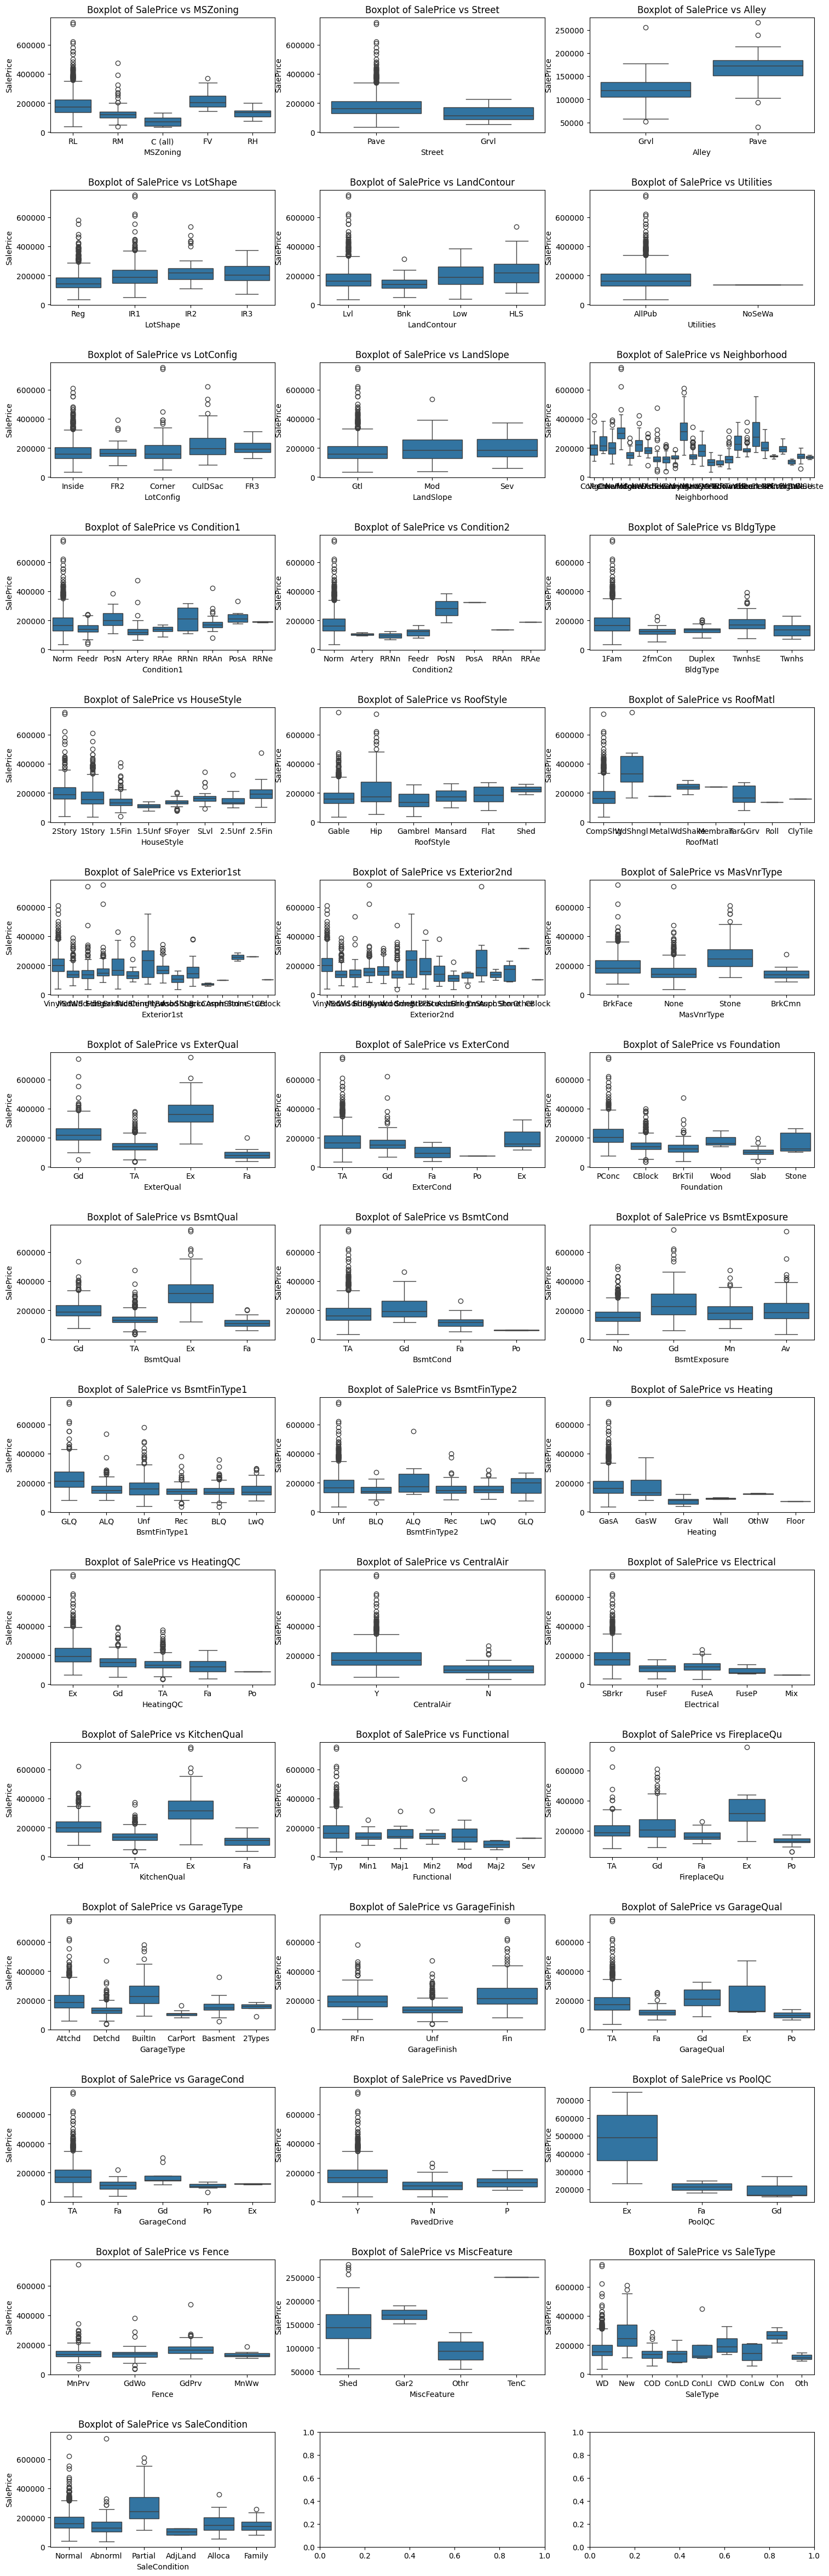

In [6]:
categorical_columns = train.select_dtypes(include='object').columns

# Calculate the number of rows and columns needed for the subplots
num_plots = len(categorical_columns)
num_rows = math.ceil(num_plots / 3)
num_cols = 3

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4 * num_rows))

# Flatten the array of axes if there is only one row
if num_rows == 1:
    axs = axs.flatten()

# Iterate over the categorical columns and plot the boxplots
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    
    if num_rows == 1:
        ax = axs[col]
    else:
        ax = axs[row, col]
    
    sns.boxplot(x=column, y='SalePrice', data=train, ax=ax)
    ax.set_title(f'Boxplot of SalePrice vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('SalePrice')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

On those charts we should look how the Median and InterQuartile Range moves in correlation with the categories/levels of each variable.
In general, I'd say that each adds some level of information to the goal of predicting `SalePrice`. 

In some cases we can think of recoding or "simplifying" some of the fields, grouping certain levels that move similarly together. Bigger but few groups should positively contribute to the estimation of the parameters reducing the variance. For now, let's keep the dataset as it is.

## Now we look at the numerical variables...
... with the always insightful variance-covariance matrix. What I like even more is plotting the matrix as a heatmap and unlocking all that valuable information to be easily captured by our eyes.

<Axes: >

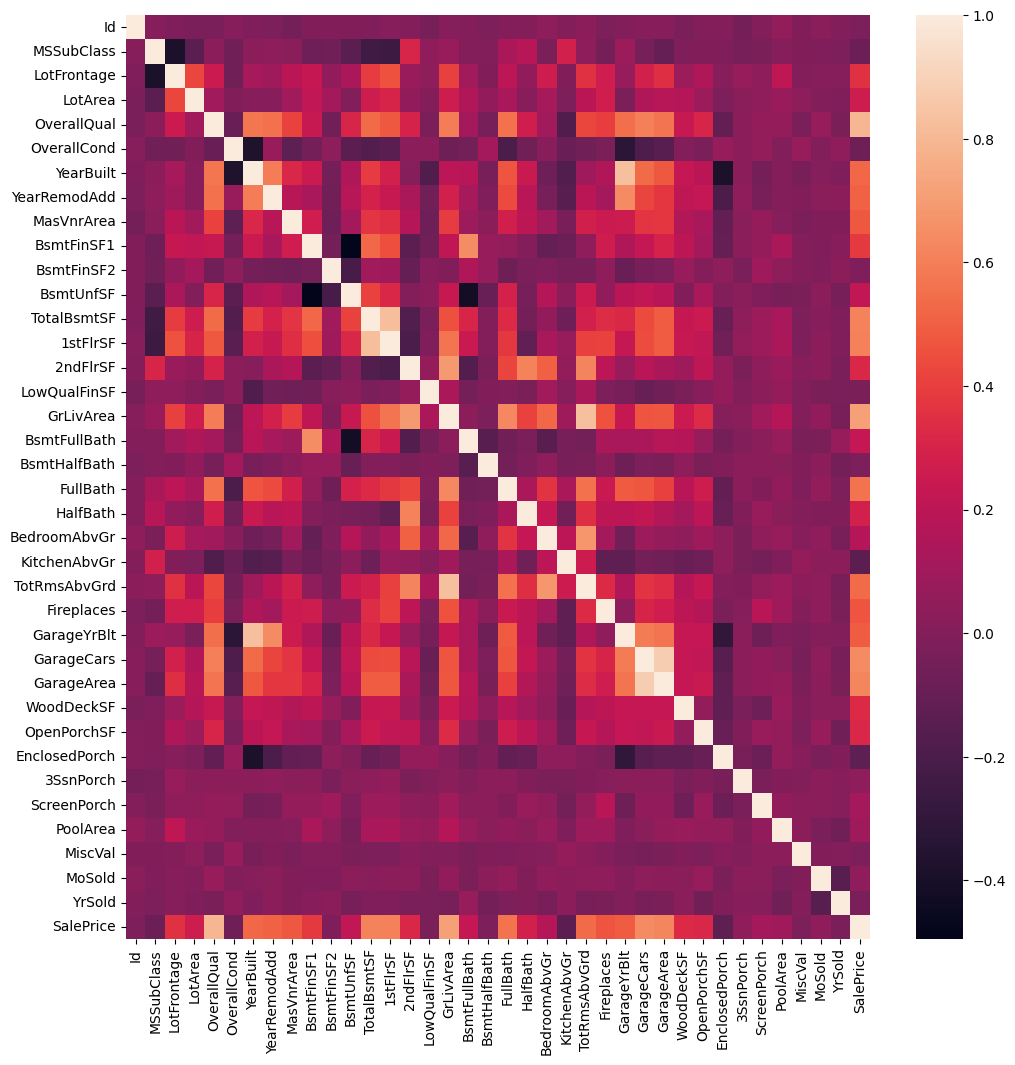

In [7]:
cov_matrix = numerical_vars.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cov_matrix)

There are quite some bright and very dark spots, which indicate strong positive and negative correlations. It's also curious how variables from `3SsnPorch` and `YrSold` range around the purple/'zero' area, especially when the correlation is computed against `SalePrice`.

The last row of this matrix should be your focal point: it tells you the relationship that exists between each variable and `SalePrice`.
Also, if you're looking for some *collinearity* to be removed look at those tan/peach and black spots. 

At the moment, I'm not going to remove any variable from the feature list. One of XGBoost's benefits is that it is quite robust against collinearity.

If you have discrete variables in your set, like `OverallQual`, is also useful to use again a Boxplot to investigate your data. Wow, look at this perfect example of correlation!

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

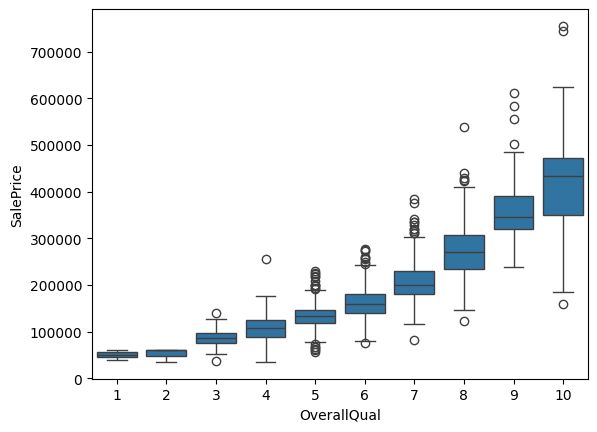

In [8]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train)

Another interesting thing to do in your EDA when having to do with numeric, and likely continuous variables is to build some scatterplots and visualize any interesting relation that the data is telling you.

Seaborn's `pairplot` is awesome in this!

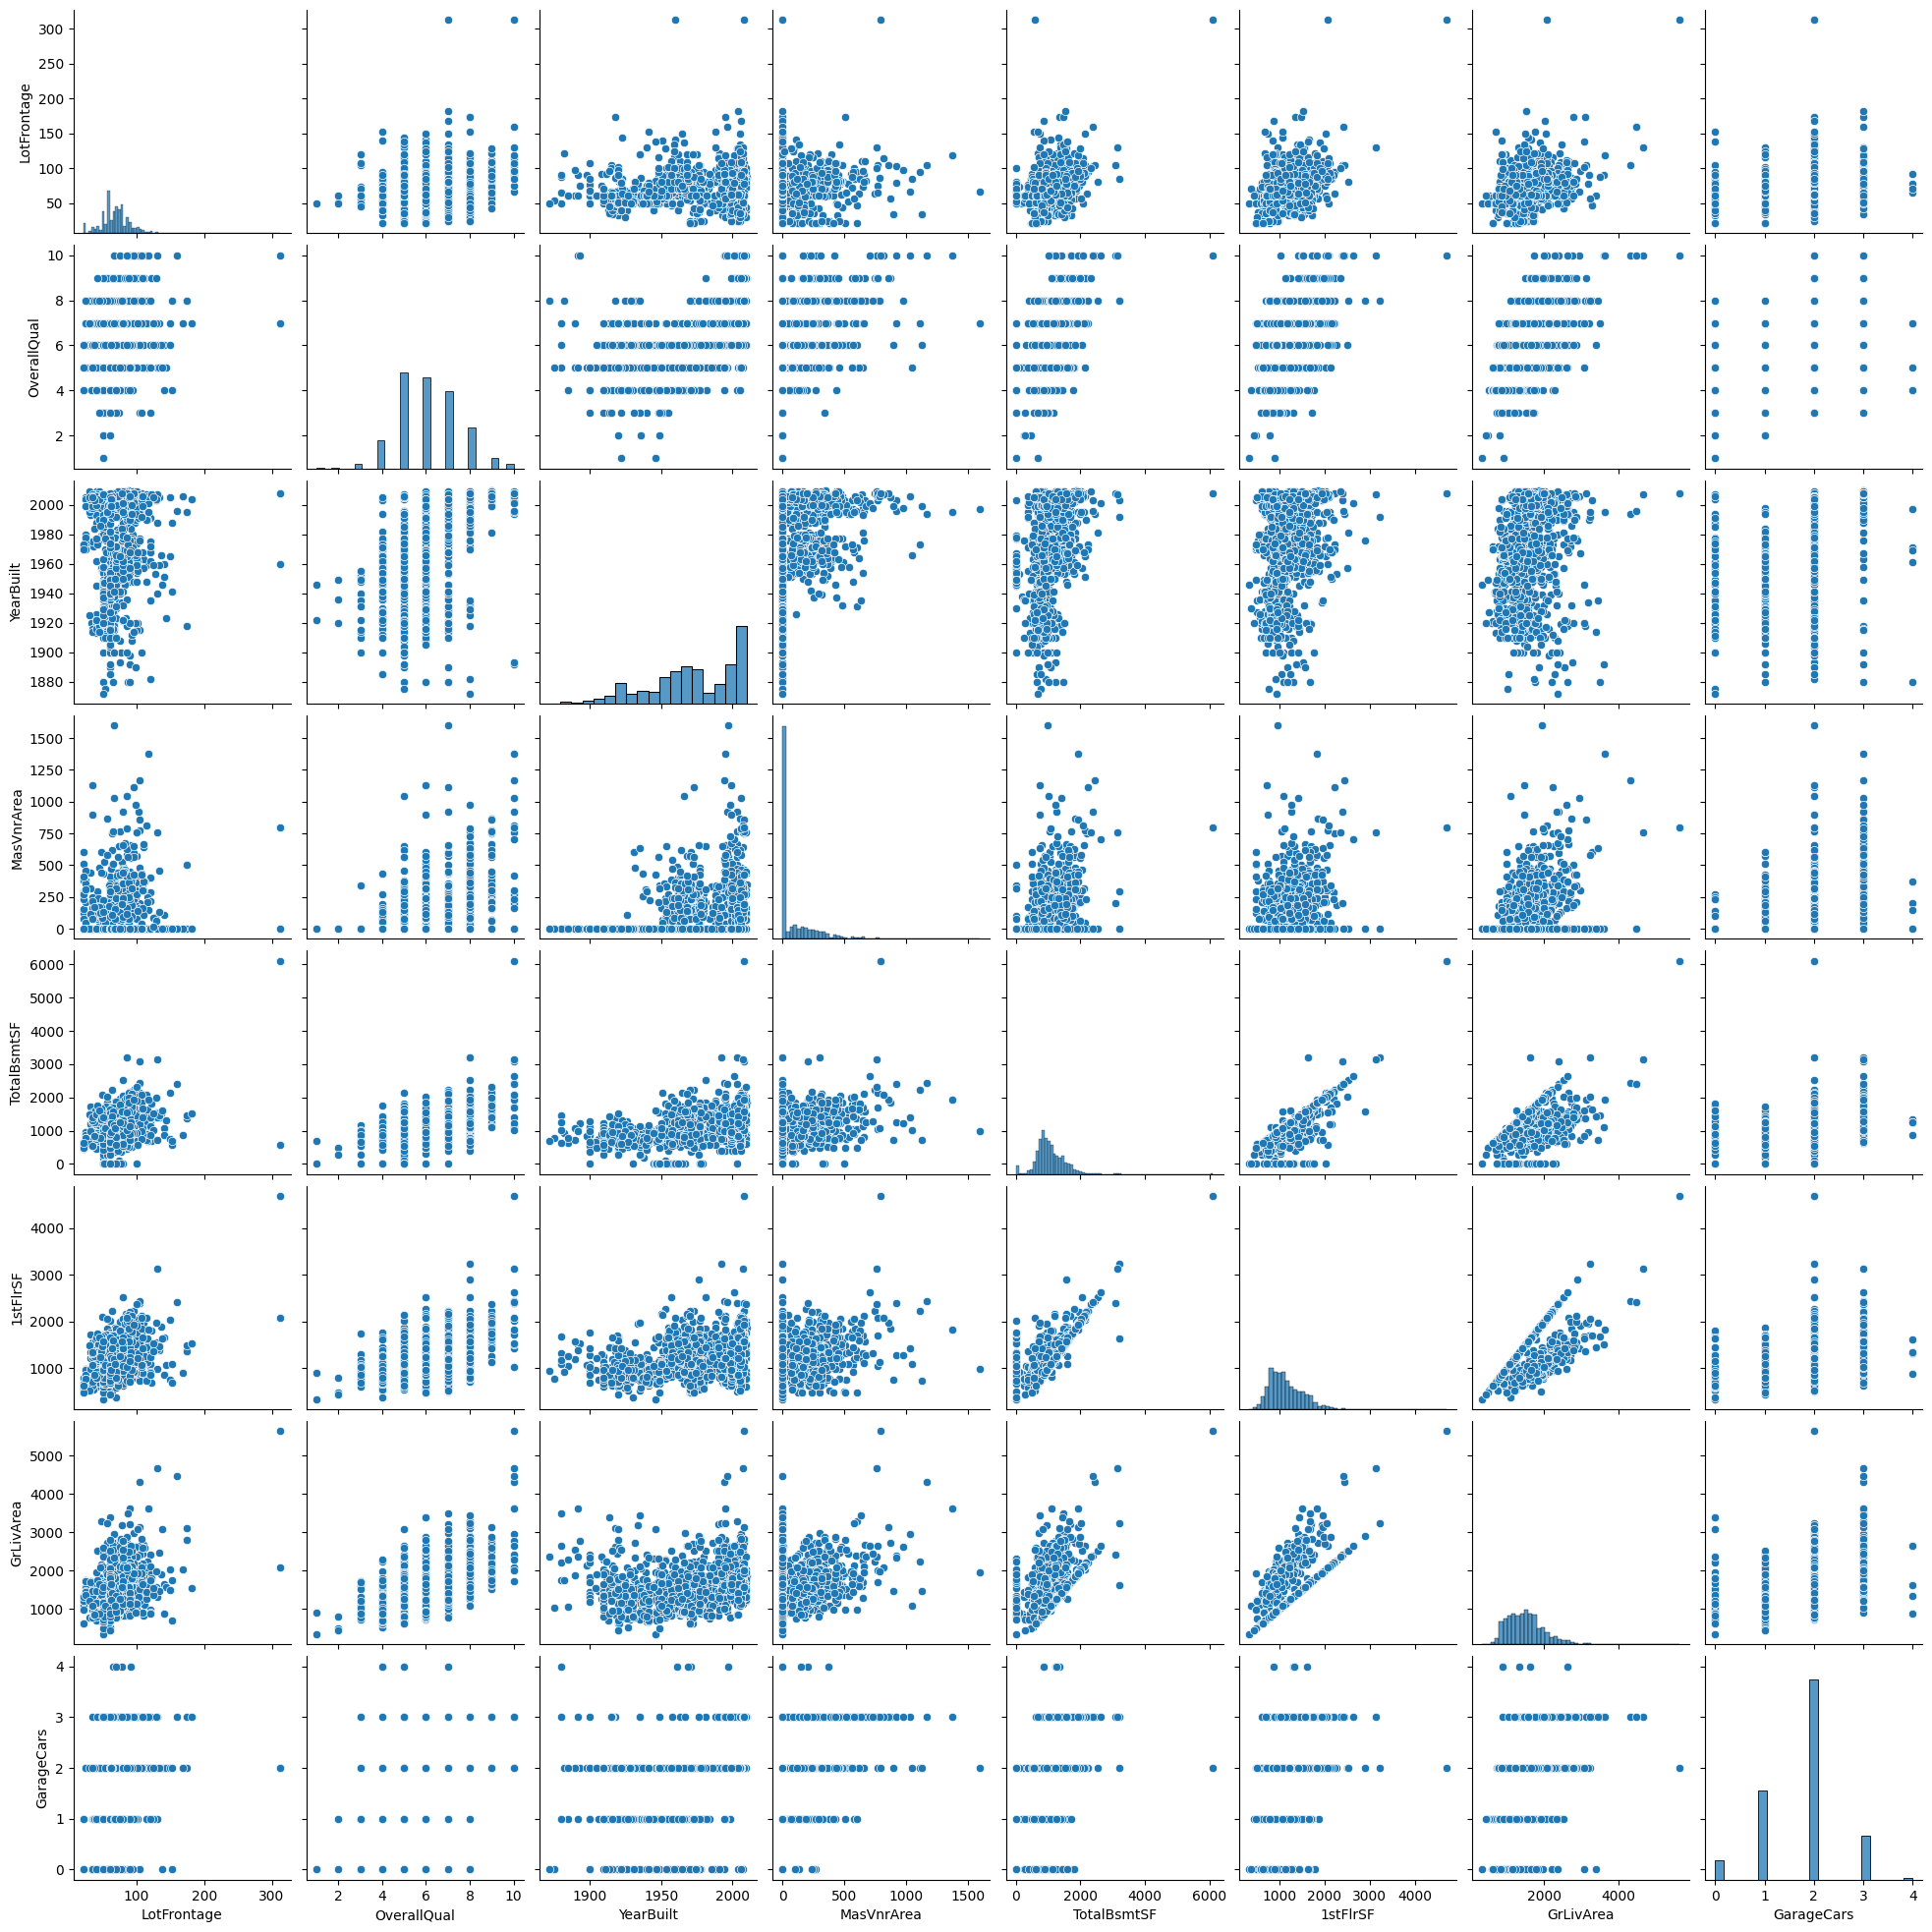

In [9]:
int_variables = ['LotFrontage','OverallQual','YearBuilt','MasVnrArea',
                 'TotalBsmtSF','1stFlrSF','GrLivArea','GarageCars']

sns.pairplot(train.loc[:,int_variables])
plt.show()

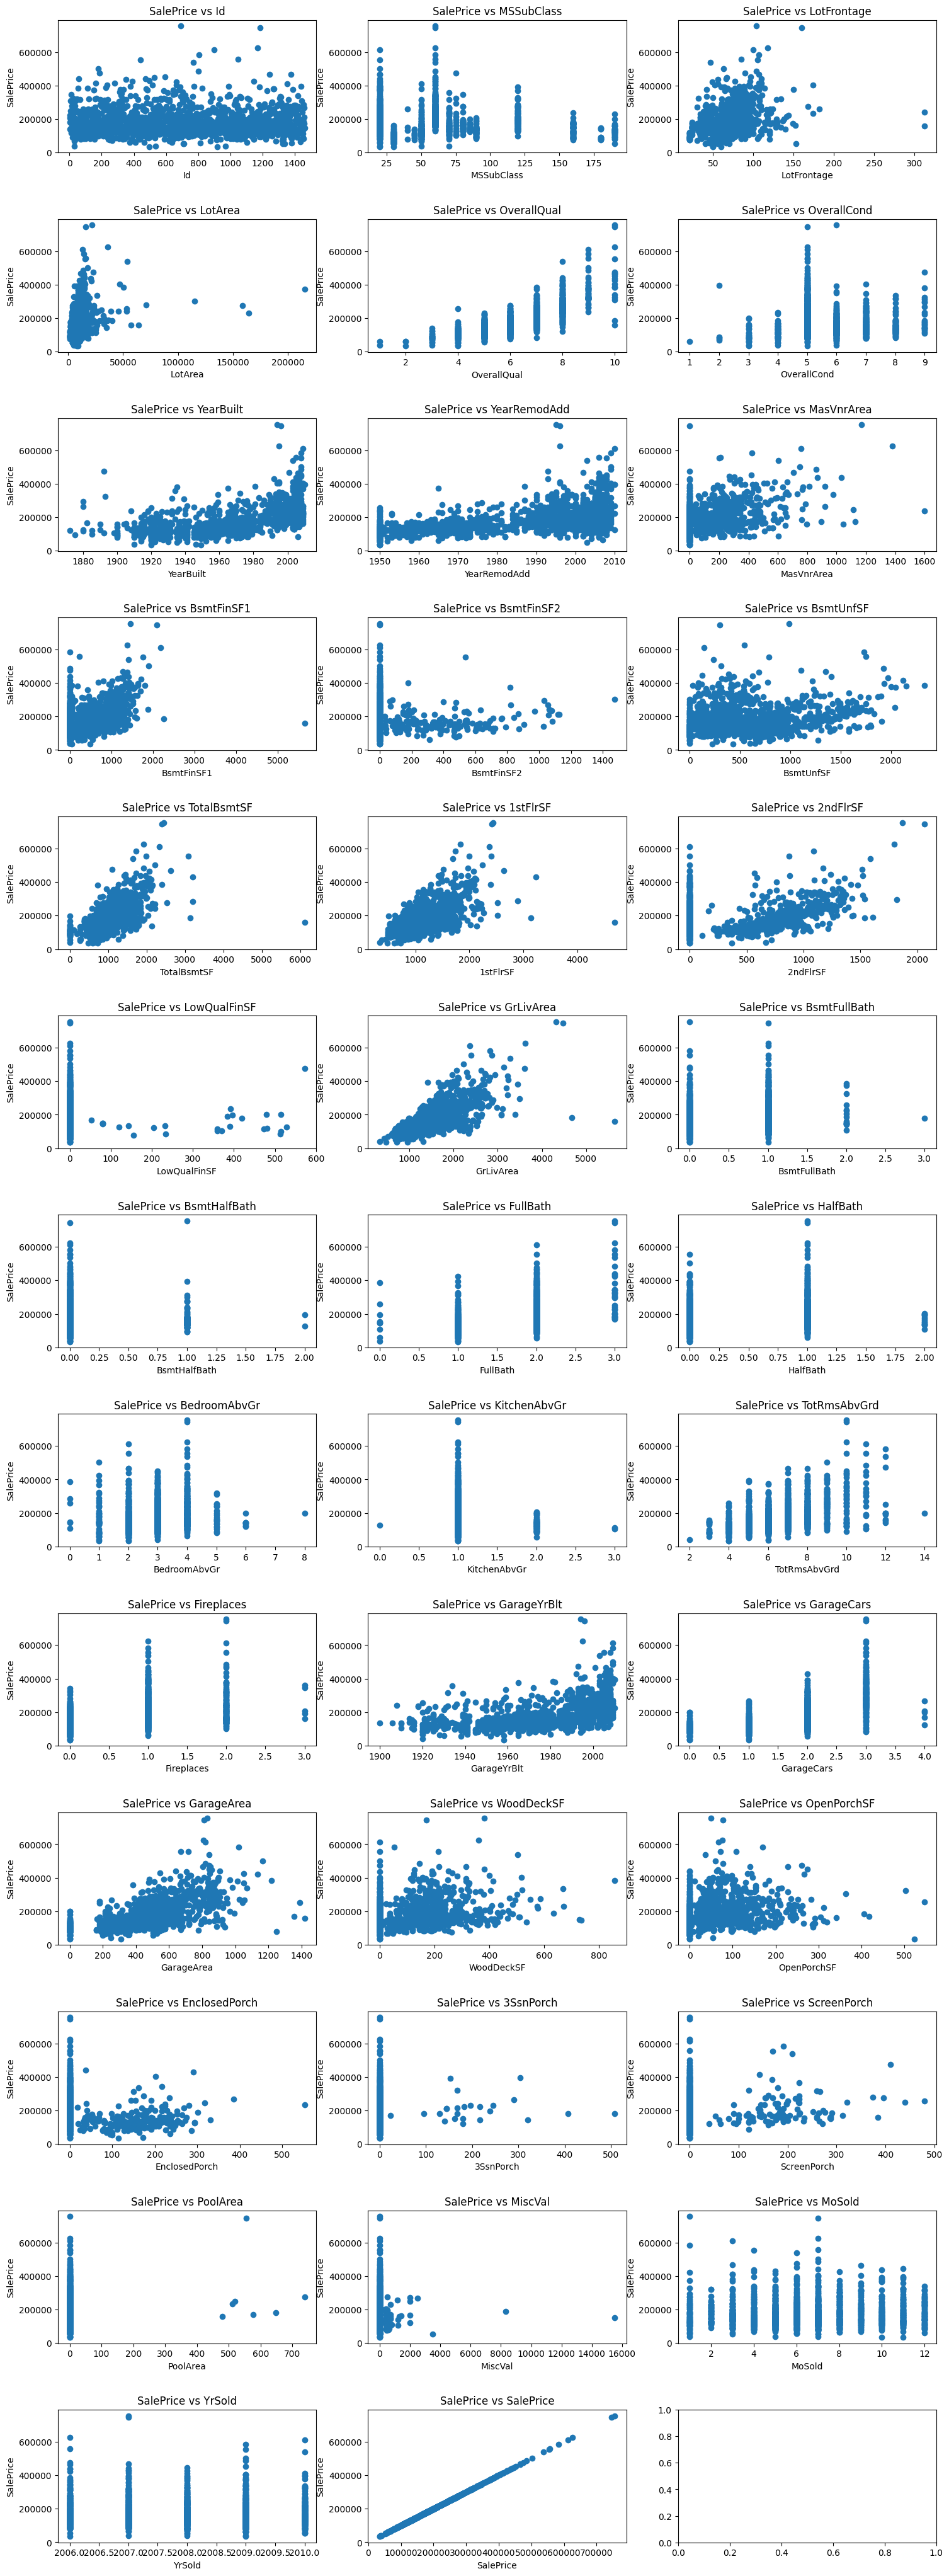

In [10]:
numerical_columns = train.select_dtypes(exclude='object').columns

# Calculate the number of rows and columns needed for the subplots
num_plots = len(numerical_columns)
num_rows = math.ceil(num_plots / 3)
num_cols = 3

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4 * num_rows))

# Flatten the array of axes if there is only one row
if num_rows == 1:
    axs = axs.flatten()

# Iterate over the categorical columns and plot the boxplots
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    
    if num_rows == 1:
        ax = axs[col]
    else:
        ax = axs[row, col]
    
    ax.scatter(train[column], train['SalePrice'])
    ax.set_title(f'SalePrice vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('SalePrice')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

Wow, there's a lot to unpack here!
First of all, `MSSubClass` doesn't seem to be really correlated in any way. I should attempt to remove it.


Also, it looks like some very big lots went sold for a cheaper price than usual, comparatively speaking, and are essentially outliers. A strategy here might be capping the lot size to the 95th or 99th percentile.

There are some variables showing an unclear correlation, in accordance with the covariance matrix. Examples are: `MasVnrArea`, `BsmtUnfSF`, `OpenPorchSF` and `EnclosedPorch`, `PoolArea`... again, we could try to remove it in order to reduce *unuseful* variability in our model but let's keep everything in our model as for now.






In [11]:
#new_train = new_train.drop(['MSSubClass','MasVnrArea','OpenPorchSF','EnclosedPorch','3SsnPorch','PoolArea','LowQualFinSF',],axis=1)


These scatter plots also made me think that it might be helpful to look at the price per square foot, which is a universally used metric in the Real Estate industry. So let's build it and plot an histogram:

<function matplotlib.pyplot.show(close=None, block=None)>

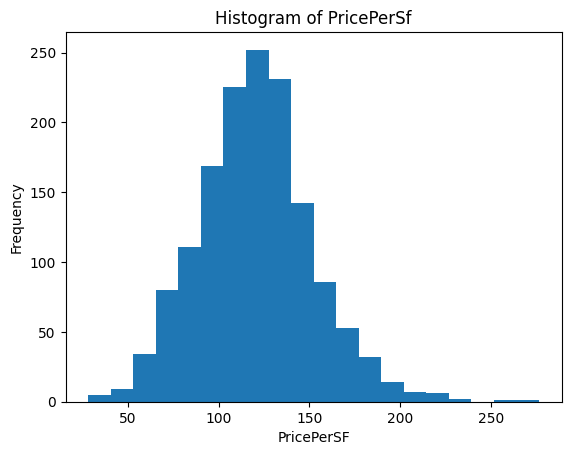

In [12]:
new_train = train
new_train['PricePerSF'] = new_train['SalePrice']/new_train['GrLivArea']
plt.hist(new_train['PricePerSF'],bins=20)
plt.xlabel('PricePerSF')
plt.ylabel('Frequency')
plt.title('Histogram of PricePerSf')
plt.show

<Axes: ylabel='PricePerSF'>

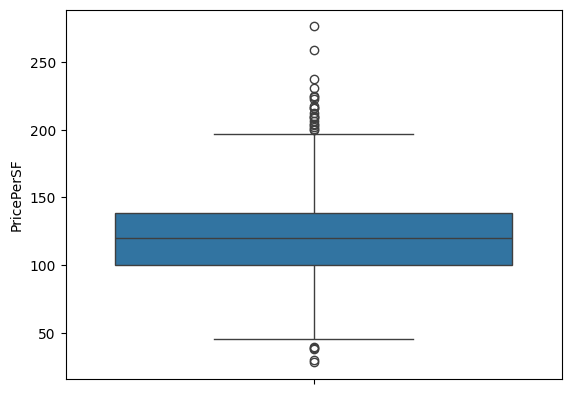

In [13]:
sns.boxplot(y='PricePerSF',data=new_train)

<function matplotlib.pyplot.show(close=None, block=None)>

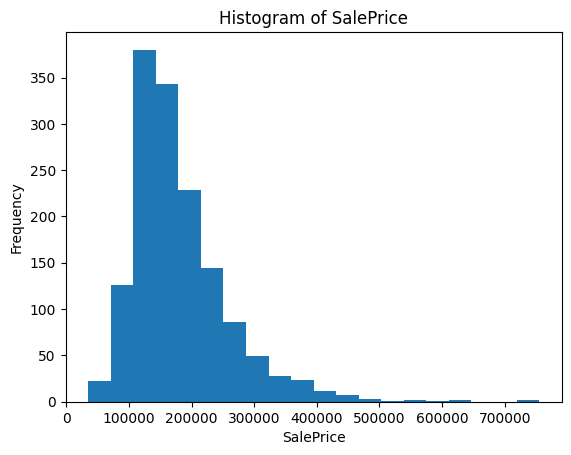

In [14]:
plt.hist(new_train['SalePrice'],bins=20)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice')
plt.show

The interesting thing is that both variables are showing some outliers, especially on the high-end/right tail of the distribution. It might be useful to remove those outliers using the simple InterQuartile Range over the `SalePrice` variable. 

In [15]:
df = new_train
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)

# Calculate IQR (Interquartile Range) for SalePrice variable
IQR = Q3 - Q1

# Define a threshold multiplier (e.g., 1.5)
threshold = 1.5

# Identify outliers for SalePrice variable
outliers = (df['SalePrice'] < (Q1 - threshold * IQR)) | (df['SalePrice'] > (Q3 + threshold * IQR))

# Remove outliers from the DataFrame
df_no_outliers = df[~outliers]
df = df_no_outliers


With a 1.5x IQR threshold we're removing 51 houses from our dataset...

In [16]:
np.shape(df)

(1399, 82)

## Encoding our categorical variables
As XGBoost doesn't natively support categorical variables, these must be encoded somehow. The most common, but not the only, is one-hot encoding: we essentially explode a categorical variable with *n* levels in *n* binary variables.

With pandas' *get_dummies*, this is a one-liner operation.

In [17]:
enc_train = pd.get_dummies(df, categorical_vars.columns)


In [18]:
enc_train.shape

(1399, 291)

Let's now build our matrix of independent variables *X* and our dependent/target *y* vector

In [19]:
X = enc_train.drop(['SalePrice','PricePerSF'],axis=1)
y = enc_train['SalePrice']

To run the necessary cross-validation (or *out-of-the-bag*) diagnostic and measure the goodness of our model we will split the training dataset in two: a random sample counting 80% of the units in the original set will be used to estimate the model, the remaining 20% to evaluate it.

In [20]:
X_train_wID, X_test_wID, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## I keep a version of the datasets including the IDs for further validation
X_train = X_train_wID.drop('Id',axis=1)
X_test = X_test_wID.drop('Id',axis=1)

## Fitting the model and tuning the parameters
Below is the basic template for fitting an XGBoost Regressor. You can also perform some hyperparameter tuning through the GridSearch method. 

In this particular case, I'm scoring/evaluating the models using RMSE (Root Mean Square Error), as this is the index used by Kaggle to score the proposed solution. However, GridSearch can evaluate a wide range of metrics: always choose the one that is aligned with the problem you want to solve or the purpose of your model.

Additionally, you can optimize your model iteratively: first start with the optimization of parameters like the learning rate (*eta*), the loss threshold (*gamma*) and the number of levels in the estimated decision trees (*max_depth*). As you can see in the example once you have found some optimal parameters you can fix them in the initialization of your model and iterate over others.

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of boosting rounds
    'reg_alpha': [0, 0.1, 0.5],          # L1 regularization term
    'reg_lambda': [0, 1, 5]              # L2 regularization term
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(eta=0.1, gamma=0, max_depth=3)

# Perform grid search with RMSE as the scoring metric
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2,n_jobs=-2)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0}


In [22]:
final_xgb_reg = xgb.XGBRegressor(eta=0.1, gamma=0, max_depth=3, **best_params)
final_xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluate your model
We estimated the model and now it's time to understand how good it is to predict our target variables using data that it has never seen. 

This is the moment when the test dataset we set apart at the beginning comes into play: we predict the sell prices from this smaller but untouch dataset and we compare the prediction with the known real prices, our *ground truth*.

_Note_: Kaggle is scoring the proposed model based on the RMSE of the logarithm of the selling price, hence you see `np.log(y_test)` in the code here below.

In [23]:
final_y_pred = final_xgb_reg.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, final_y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(final_y_pred)))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error: 369774591.648764
Root Mean Squared Error (RMSE): 0.12044006992279811


Our RMSE is approximately 0.12, which isn't too bad in absolute terms but still far from the top of the leaderboard.

It's always good practice to check the basic diagnostic of any regression, how our residuals look like, to understand how our model is performing and how it can be improved.

First thing: are our residuals independently distributed and with a homogeneous variance against our *y*?

Secondly: are our residuals normally distributed?

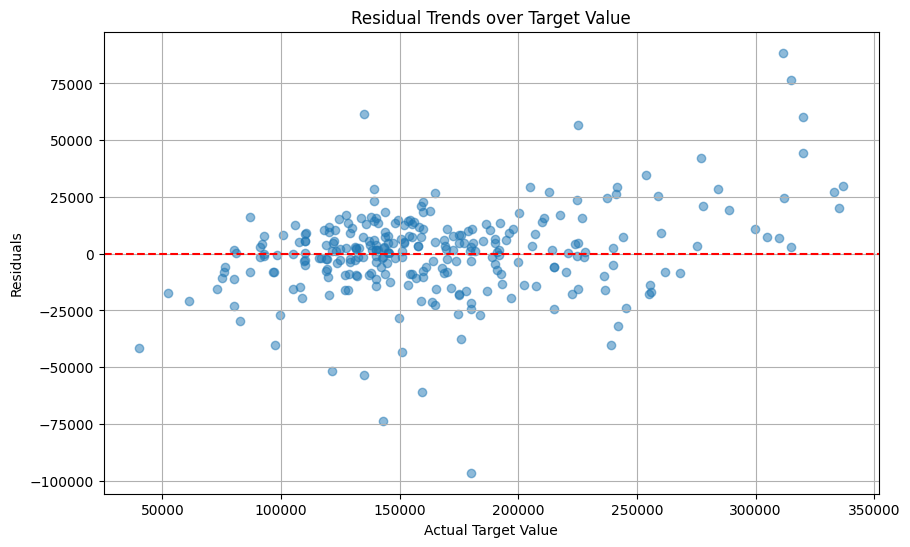

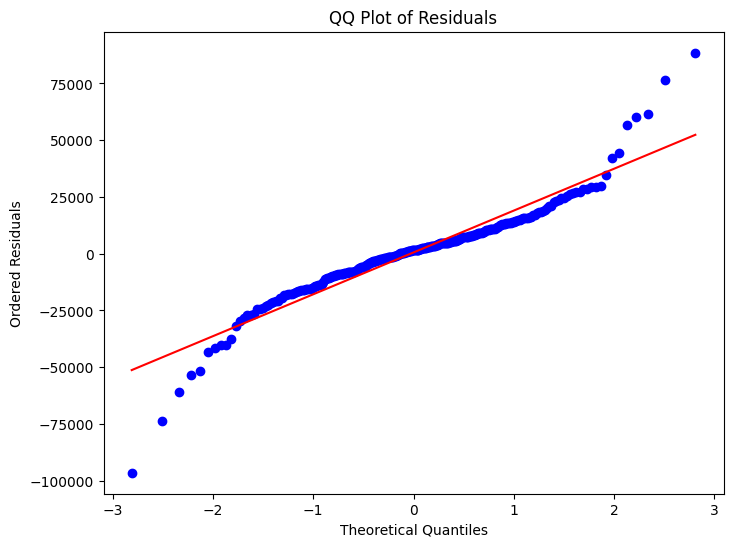

In [24]:
# Calculate residuals
residuals = y_test - final_y_pred

# Plot residual trends over target value
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Actual Target Value')
plt.ylabel('Residuals')
plt.title('Residual Trends over Target Value')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Generate QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')
plt.show()

My model seems to work decently in the most common price range but degrading a little on the higher-end of the price spectrum.

We can stack an additional model, this time working on the residuals of the first estimated, to capture some "hidden" correlation that wasn't modeled in the first iteration.

Here below you have the basic template to stack two models, where the final prediction is the combination of those interim phases.

In [25]:
X_new = X_test.copy()
#X_new['residuals'] = residuals

hgb_reg = HistGradientBoostingRegressor(random_state=42,learning_rate=0.3)
hgb_reg.fit(X_new, residuals)

# Combine predictions from both models
final_predictions = final_y_pred + hgb_reg.predict(X_new)

# Evaluate the final predictions
from sklearn.metrics import mean_squared_error
print("Mean Squared Error:", mean_squared_error(y_test, final_predictions))
rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(final_predictions)))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error: 1345722.1018344166
Root Mean Squared Error (RMSE): 0.007251665599352322


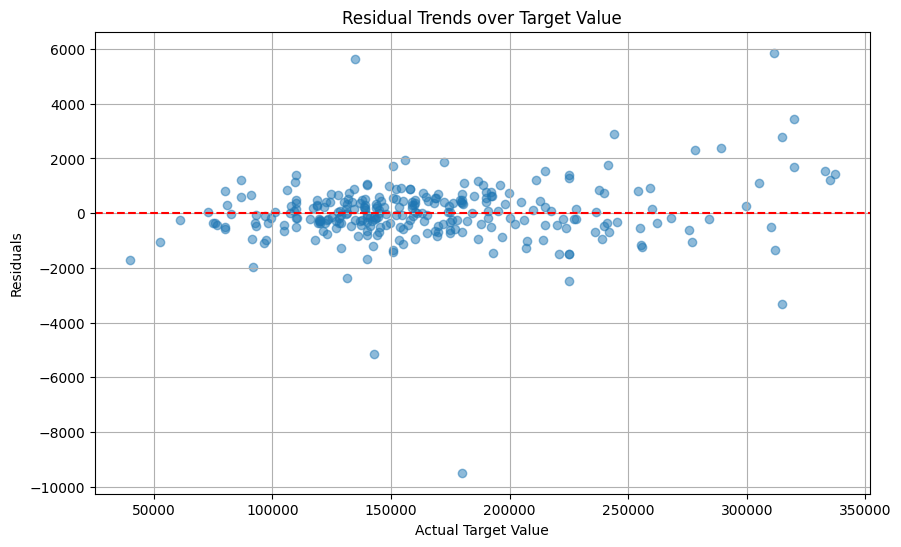

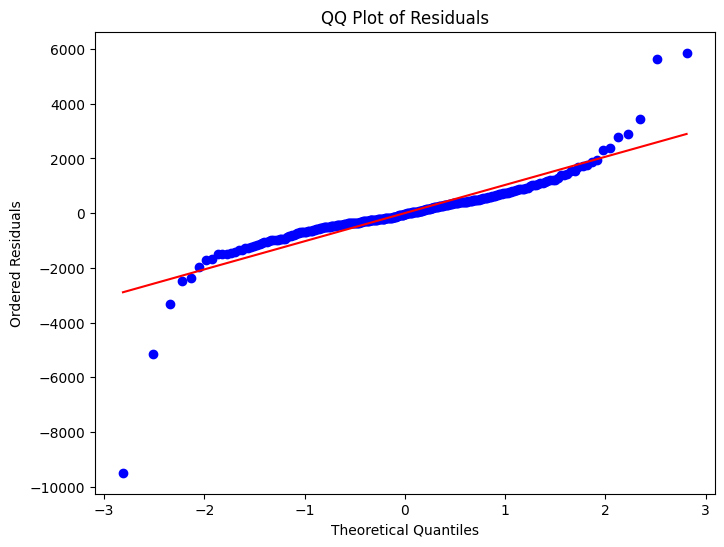

In [26]:
final_residuals = y_test - final_predictions

# Plot residual trends over target value
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_residuals, alpha=0.5)
plt.xlabel('Actual Target Value')
plt.ylabel('Residuals')
plt.title('Residual Trends over Target Value')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Generate QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(final_residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')
plt.show()

My model still isn't working well on extreme values but if you look now at the scale of the residuals/error we're much closer to the truth: where before it was missing real price by \\$100-70k now is around \$5-6k!

## Let's build our submission!

Here below you have the necessary code to treat the `Test` dataset upon which our submission to the context will be based and to perform the two-stage inference phase in order to produce our predict sell prices.

In [27]:
#### Predicting REAL TEST PRICES #####
#test = test.drop(['MSSubClass','MasVnrArea','OpenPorchSF','EnclosedPorch','3SsnPorch','PoolArea','LowQualFinSF'],axis=1)
test_cat_vars = test.select_dtypes(include='object')  # Select object data type columns

In [28]:
enc_test = pd.get_dummies(test, test_cat_vars.columns)

## The Test sample might not contain instances of each level for each original categorical variable. 
## If this happens, the model will complain about some missing independent variables. 
## Always start from the original data structure used to estimate the model, and (like in a UNION statement) add your new data
empty_df = pd.DataFrame({col: pd.Series(dtype=dtype) for col, dtype in zip(enc_train.columns, enc_train.dtypes)})
merged_test = pd.concat([empty_df, enc_test], axis=0, ignore_index=True)
merged_test.shape

(1459, 291)

In [29]:
real_test = merged_test.drop(['Id','SalePrice','PricePerSF'],axis=1)
pass1_y_pred = final_xgb_reg.predict(real_test)

pass2_y_pred = pass1_y_pred + hgb_reg.predict(real_test)

In [30]:
real_predictions_series = pd.Series(pass2_y_pred)

# Create a new DataFrame by combining 'Id' column and final_predictions_series
result_df = pd.DataFrame({'Id': test['Id'].reset_index(drop=True), 'SalePrice': real_predictions_series})

# Print the new DataFrame
print(result_df)

        Id      SalePrice
0     1461  110745.966404
1     1462  140519.911944
2     1463  203946.106442
3     1464  180113.146725
4     1465  187359.402947
...    ...            ...
1454  2915   78770.369907
1455  2916   73870.655195
1456  2917  141044.911367
1457  2918  130778.809137
1458  2919  223736.465060

[1459 rows x 2 columns]


In [31]:
result_df.to_csv('submission.csv', index=False)


## What's next?
With this analysis and model estimation, you'll score an RMSE of 0.1638, which places you around the 3000th position among almost 5,000 entries.

In the next phase we could go deeper into what is generally called "feature engineering": transforming the raw variables building our dataset in ways that can boost the right signals, reduce the space of the problem (fewer variables) and ultimately improve the precision of our model.